## Analysis of multiple files

This notebook illustrates how to read multiple textgrids, compile them into a single dataframe, and collect corresponding acoustic signals.

Look for `# TODO` to find places where you might make changes to do your own analysis.

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.io.wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd

from eggd800.signal import butter_lowpass_filter
from audiolabel import read_label
from phonlab.utils import dir2df, match_tokentimes, adjust_boundaries

In [2]:
datadir = Path(
    '/Users/ronald/Library/CloudStorage/Box-Box/amazon_nasality_grant/data_analysis/Jorge_analysis/old'
)
wavdir = Path(
    '/Users/ronald/Library/CloudStorage/Box-Box/cla/projects/digital_queues/external_depositors/cla_amazonian-nasality_data-for-archiving/006_jorge_emilio_roses_labrada'
)

Get dataframes of textgrids and .wav files to analyze. Extract experiment variables from the filenames. Since this notebook is just for illustration we limit the number of textgrids to the value in `tglimit` to keep the number of rows manageable.

In [3]:
tglimit = 4
tgdf = dir2df(
    datadir,
    fnpat='(?P<lang>[^_]+)_(?P<spkr>[^_]+)_(?P<researcher>[^_]+)_(?P<tstamp>[^_]+)_(?P<item>.+)_(?P<rep>\d+)\.TextGrid',
    addcols=['barename']
)
tgdf['rep'] = tgdf['rep'].astype(int)   #### Optional, depending on how you want to use this column ####
tgdf = tgdf.iloc[:tglimit]  #### Remove this line if you want to process all textgrids ####
tgdf

,relpath,fname,barename,lang,spkr,researcher,tstamp,item,rep
0,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0.T...,pid_ros_jrl_20220512T110242__removeraguaM__0,pid,ros,jrl,20220512T110242,_removeraguaM_,0
1,pid/ros/20220512,pid_ros_jrl_20220512T110301__removeraguaF__0.T...,pid_ros_jrl_20220512T110301__removeraguaF__0,pid,ros,jrl,20220512T110301,_removeraguaF_,0
2,pid/ros/20220512,pid_ros_jrl_20220512T110332__quebrarM__0.TextGrid,pid_ros_jrl_20220512T110332__quebrarM__0,pid,ros,jrl,20220512T110332,_quebrarM_,0
3,pid/ros/20220512,pid_ros_jrl_20220512T110354__quebrarF__0.TextGrid,pid_ros_jrl_20220512T110354__quebrarF__0,pid,ros,jrl,20220512T110354,_quebrarF_,0


In [4]:
wavdf = dir2df(
    wavdir,
    fnpat='(?P<lang>[^_]+)_(?P<spkr>[^_]+)_(?P<researcher>[^_]+)_(?P<tstamp>[^_]+)_(?P<item>.+)_(?P<rep>\d+)\.wav',
    addcols=['barename']
)
wavdf

,relpath,fname,barename,lang,spkr,researcher,tstamp,item,rep
0,pid/aop/20220512,pid_aop_jrl_20220512T090321__zero__0.wav,pid_aop_jrl_20220512T090321__zero__0,pid,aop,jrl,20220512T090321,_zero_,0
1,pid/aop/20220512,pid_aop_jrl_20220512T090455__beberM__0.wav,pid_aop_jrl_20220512T090455__beberM__0,pid,aop,jrl,20220512T090455,_beberM_,0
2,pid/aop/20220512,pid_aop_jrl_20220512T090519__beberF__0.wav,pid_aop_jrl_20220512T090519__beberF__0,pid,aop,jrl,20220512T090519,_beberF_,0
3,pid/aop/20220512,pid_aop_jrl_20220512T090546__entrarM__0.wav,pid_aop_jrl_20220512T090546__entrarM__0,pid,aop,jrl,20220512T090546,_entrarM_,0
4,pid/aop/20220512,pid_aop_jrl_20220512T090703__entrarM__1.wav,pid_aop_jrl_20220512T090703__entrarM__1,pid,aop,jrl,20220512T090703,_entrarM_,1
...,...,...,...,...,...,...,...,...,...
995,pid/ros/20220518,pid_ros_jrl_20220518T144941__zero__1.wav,pid_ros_jrl_20220518T144941__zero__1,pid,ros,jrl,20220518T144941,_zero_,1
996,pid/ros/20220518,pid_ros_jrl_20220518T145005__bannarseM__0.wav,pid_ros_jrl_20220518T145005__bannarseM__0,pid,ros,jrl,20220518T145005,_bannarseM_,0
997,pid/ros/20220518,pid_ros_jrl_20220518T145100__bannarseM__1.wav,pid_ros_jrl_20220518T145100__bannarseM__1,pid,ros,jrl,20220518T145100,_bannarseM_,1
998,pid/ros/20220518,pid_ros_jrl_20220518T145120__bannarseF__0.wav,pid_ros_jrl_20220518T145120__bannarseF__0,pid,ros,jrl,20220518T145120,_bannarseF_,0


## Define functions

For every textgrid we will extract experiment metadata and acoustic signals. The following functions are defined to help compile these results.

In [5]:
def get_sigs(wavfile, chan=['audio', 'orfl', None, 'nsfl'], cutoff=50, order=3):
    '''
    Get signals from `wavfile`.
    
    Parameters
    ----------
    
    wavfile : Path or str
    The .wav file to read.
    
    chan : list of str
    A list of signal channels in the order that they occur in the wavfile. Use
    None as a placeholder for a channel from wavfile that will not be returned.
    Channels named 'orfl' and 'nsfl' will be filtered.
    
    cutoff : num or None
    Cutoff value of the lowpass butterworth filter for 'orfl' and 'nsfl' signals.
    If None, do not lowpass filter flow signals.
    
    order : int
    Order of the lowpass butterworth filter for 'orfl' and 'nsfl' signals.
    
    Returns
    -------
    Tuple consisting of:
    
    rate : num
    Data sample rate.
    
    ts : array
    Times corresponding to each sample value.
    
    arrays : array
    An array for each non-None value passed as `chan`. With the default value of
    `chan` three arrays are returned, for a total of five elements in the returned
    tuple.
    '''
    chanmap = {c: idx for idx, c in enumerate(chan) if c is not None}
    (rate, data) = scipy.io.wavfile.read(wavfile)
    ts = np.arange(data.shape[0]) / rate
    if cutoff is not None:
        if 'orfl' in chan:
            data[:, chanmap['orfl']] = butter_lowpass_filter(
                data[:, chanmap['orfl']], cutoff, rate, order
            )
        if 'nsfl' in chan:
            data[:, chanmap['nsfl']] = butter_lowpass_filter(
                data[:, chanmap['nsfl']], cutoff, rate, order
            )
    return (rate, ts, *[data[:, c] for c in chanmap.values()])

# TODO: elaborate as needed for the project--additional columns or merge additional
# tiers.
def tg2df(row, datadir, tiernames, fields, tolerance):
    '''Load 'phone' and 'word' tiers from a textgrid and merge them.
    
    Parameters
    ----------
    
    row: named tuple
    A namedtuple as provided by `itertuples` that can be used to load a Praat
    textgrid from a path identified by row.relpath and row.fname. The textgrid is
    expected to have 'phone', 'word', and 'notes' tiers.
    
    datadir: Path
    Base path where `row.relpath` is located.

    tiernames: dict
    Dictionary that maps 'phone' and 'word' keys to the names of the corresponding
    tiers in the textgrid.

    fields: list of str
    Names of fields from `row` to include in the returned dataframe.
    
    tolerance: float
    Maximum amount word boundaries can be adjusted relative to phone boundaries.

    Returns
    -------
    
    phwddf: the merged phone-word dataframe.
    '''
    fpath = datadir / row.relpath / row.fname
    [phdf, wddf] = read_label(
        fpath,
        ftype='praat',
        tiers=[tiernames['phone'], tiernames['word']]
    )
    phdf = phdf.rename({tiernames['phone']: 'phone'}, axis='columns')
    wddf = wddf.rename({tiernames['word']: 'word'}, axis='columns')

    # Ensure that word boundaries exactly match a phone boundary.
    for bndry in ('t1', 't2'):
        try:
            wddf[bndry] = adjust_boundaries(wddf[bndry], phdf[bndry], tolerance=tolerance)
        except ValueError as e:
            badt = ', '.join([f'{t:0.4f}' for t in e.args[1]])
            msg = f"Word-phone boundary mismatch greater than {tolerance} in {fpath}. " \
                  f"Bad word boundary found at time(s) {badt}."
            raise ValueError(msg) from None
        assert(wddf[bndry].isin(phdf[bndry]).all())

    # TODO: This is a good place to add columns to phdf and wddf. For example, calculate
    # durations or midpoints. For other possibilities (e.g. next/previous phone) see
    # https://github.com/rsprouse/audiolabel/blob/master/doc/working_with_phonetic_dataframes.ipynb.
    phdf['dur_ph'] = phdf.t2 - phdf.t1
    phdf['midpt'] = (phdf.t1 + phdf.t2) / 2.0

    # Merge phone and word tiers.
    phwddf = pd.merge_asof(
        phdf.rename({'t1': 't1_ph', 't2': 't2_ph'}, axis='columns'),
        wddf.drop('fname', axis='columns') \
            .rename({'t1': 't1_wd', 't2': 't2_wd'}, axis='columns'),
        left_on='t1_ph',
        right_on='t1_wd'
    )

    # TODO: This is a good place to add columns to the merged df. For example,
    # determine word-initiality and -finality of phones.
    phwddf['is_wdinit_ph'] = phwddf.t1_ph == phwddf.t1_wd
    phwddf['is_wdfin_ph'] = phwddf.t2_ph == phwddf.t2_wd

    # TODO: If you have another tier you want to add to your dataframe, follow
    # the pattern seen above to merge it with phwddf here and return that
    # instead of phwddf.

    # Add metadata columns from `row` and return.
    return pd.concat(
        [phwddf, pd.DataFrame([row] * len(phwddf)).loc[:, fields]],
        axis='columns'
    )

## Assemble dataframe of tokens

Iterate over the rows of `tgdf` and use the `tg2df` function to extract phone-word metadata into dataframes, which are ultimately assembled into a master dataframe `tokdf` of all the tokens found in the textgrids.

Use `tgfields` to select columns from `tgdf` that you wish to include in `tokdf`.

The `tiernames` and `tol` variables have been included in case textgrids were not created exactly and consistently.
If you enforce exact standards on the textgrids then these could be removed from the code. If every textgrid has tiers named 'segments' and 'words', for example, then those values could be hardcoded into the `tg2df` function, and an error would be raised for any textgrid that doesn't have the right tier names.

Ideally word boundaries would exactly line up with phone boundaries, but hand-created textgrid annotations frequently don't line up exactly. The `tol` value allows for some slop in the misalignment.

In [6]:
# Columns from `tgdf` that we want in our new df.
tgfields = ['item', 'spkr', 'tstamp', 'relpath', 'barename']

# The names of the tiers in the textgrid that correspond to the
# the 'phone' and 'word' columns in the dataframe returned by `tg2df`.
tiernames = {
    'phone': 'segments',
    'word': 'words'
}

# Tolerance of word boundary adjustment, in seconds.
# Word boundaries should exactly match a phone boundary. If the textgrid was
# constructed loosely, word boundaries will be adjusted to the nearest phone
# boundary, up to this tolerance value. An error is raised if no phone
# boundary exists within the tolerance range.
tol = 0.005

# Assemble of list of dataframes per textgrid, then concatenate into one
# large dataframe.
dflist = []
for row in tgdf.itertuples():
    dflist.append(
        tg2df(row, datadir, tiernames=tiernames, fields=tgfields, tolerance=tol)
    )

tokdf = pd.concat(dflist, ignore_index=True)
tokdf

,t1_ph,t2_ph,phone,fname,dur_ph,midpt,t1_wd,t2_wd,word,is_wdinit_ph,is_wdfin_ph,item,spkr,tstamp,relpath,barename
0,0.000000,3.075805,,/Users/ronald/Library/CloudStorage/Box-Box/ama...,3.075805,1.537903,0.000000,3.075805,,True,True,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0
1,3.075805,3.159182,t͡ʃ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.083377,3.117494,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,True,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0
2,3.159182,3.234424,ĩ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.075242,3.196803,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0
3,3.234424,3.346271,w̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.111847,3.290347,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0
4,3.346271,3.396093,ĩ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.049823,3.371182,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,10.764298,10.794526,h,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.030228,10.779412,10.000349,11.100472,t͡ʃit’ets’ækʷæhusæ,False,False,_quebrarF_,ros,20220512T110354,pid/ros/20220512,pid_ros_jrl_20220512T110354__quebrarF__0
240,10.794526,10.833914,u,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.039388,10.814220,10.000349,11.100472,t͡ʃit’ets’ækʷæhusæ,False,False,_quebrarF_,ros,20220512T110354,pid/ros/20220512,pid_ros_jrl_20220512T110354__quebrarF__0
241,10.833914,10.935591,s,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.101677,10.884753,10.000349,11.100472,t͡ʃit’ets’ækʷæhusæ,False,False,_quebrarF_,ros,20220512T110354,pid/ros/20220512,pid_ros_jrl_20220512T110354__quebrarF__0
242,10.935591,11.100472,æ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.164881,11.018031,10.000349,11.100472,t͡ʃit’ets’ækʷæhusæ,False,True,_quebrarF_,ros,20220512T110354,pid/ros/20220512,pid_ros_jrl_20220512T110354__quebrarF__0


## Select tokens to analyze

Reduce the rows to those that will be analyzed. In this example the vowel tokens are selected and stored as `vowdf`.

In [7]:
nasalvowels = ['ĩ', 'æ̃', 'ɑ̃', 'ẽ']
oralvowels = ['i', 'æ', 'u', 'e']
vowdf = tokdf[tokdf['phone'].isin(nasalvowels + oralvowels)].copy()  # .copy() helps avoid warnings if you add to vowdf later
vowdf['is_nasal'] = vowdf['phone'].isin(nasalvowels)   # Example of variable you might add to add to your model
vowdf

,t1_ph,t2_ph,phone,fname,dur_ph,midpt,t1_wd,t2_wd,word,is_wdinit_ph,is_wdfin_ph,item,spkr,tstamp,relpath,barename,is_nasal
2,3.159182,3.234424,ĩ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.075242,3.196803,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
4,3.346271,3.396093,ĩ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.049823,3.371182,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
6,3.428630,3.535393,æ̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.106763,3.482012,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
8,3.684861,3.777388,ɑ̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.092528,3.731125,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
10,3.897369,4.072000,æ̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.174631,3.984685,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,True,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,10.287975,10.401560,e,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.113585,10.344767,10.000349,11.100472,t͡ʃit’ets’ækʷæhusæ,False,False,_quebrarF_,ros,20220512T110354,pid/ros/20220512,pid_ros_jrl_20220512T110354__quebrarF__0,False
236,10.504152,10.621401,æ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.117249,10.562777,10.000349,11.100472,t͡ʃit’ets’ækʷæhusæ,False,False,_quebrarF_,ros,20220512T110354,pid/ros/20220512,pid_ros_jrl_20220512T110354__quebrarF__0,False
238,10.702010,10.764298,æ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.062288,10.733154,10.000349,11.100472,t͡ʃit’ets’ækʷæhusæ,False,False,_quebrarF_,ros,20220512T110354,pid/ros/20220512,pid_ros_jrl_20220512T110354__quebrarF__0,False
240,10.794526,10.833914,u,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.039388,10.814220,10.000349,11.100472,t͡ʃit’ets’ækʷæhusæ,False,False,_quebrarF_,ros,20220512T110354,pid/ros/20220512,pid_ros_jrl_20220512T110354__quebrarF__0,False


## Load the signals

Next we apply the [split-apply-combine](https://pandas.pydata.org/docs/user_guide/groupby.html) concept to `vowdf` to load the acoustic and flow signals.

First we split the tokens into groups by source textgrid (which corresponds to a .wav file). A function that loads the acoustic and flow signals is applied to each group of tokens, and finally the signals that are returned are combined into lists of signals, where each signal in the list corresponds to a row in `vowdf`.

In [8]:
aud = []    # List of audio signals for each token
orfl = []   # List of oral flow signals for each token
nsfl = []   # List of nasal flow signals for each token
times = []  # List of sample times for each token
rate = None
for name, group in vowdf.groupby(['relpath', 'barename']):
    # Each value of group is a dataframe. Use .iloc[0] to grab the first entry in each.
    wavpath = wavdir / group['relpath'].iloc[0] / f"{group['barename'].iloc[0]}.wav"
    print(wavpath)
    _rate, ts, audsig, orflsig, nsflsig = get_sigs(wavpath)
    # We expect sample rate to be the same for all acquisitions. Throw an error if that's not true.
    if rate is None:
        rate = _rate
    else:
        assert(rate == _rate)
    # Now extract samples for each token from the signals.
    for tokrow in group.itertuples():
        rng = np.arange(int(tokrow.t1_ph * rate), int(tokrow.t2_ph * rate))
        aud.append(audsig[rng])
        orfl.append(orflsig[rng])
        nsfl.append(nsflsig[rng])
        times.append(ts[rng])

/Users/ronald/Library/CloudStorage/Box-Box/cla/projects/digital_queues/external_depositors/cla_amazonian-nasality_data-for-archiving/006_jorge_emilio_roses_labrada/pid/ros/20220512/pid_ros_jrl_20220512T110242__removeraguaM__0.wav
/Users/ronald/Library/CloudStorage/Box-Box/cla/projects/digital_queues/external_depositors/cla_amazonian-nasality_data-for-archiving/006_jorge_emilio_roses_labrada/pid/ros/20220512/pid_ros_jrl_20220512T110301__removeraguaF__0.wav
/Users/ronald/Library/CloudStorage/Box-Box/cla/projects/digital_queues/external_depositors/cla_amazonian-nasality_data-for-archiving/006_jorge_emilio_roses_labrada/pid/ros/20220512/pid_ros_jrl_20220512T110332__quebrarM__0.wav
/Users/ronald/Library/CloudStorage/Box-Box/cla/projects/digital_queues/external_depositors/cla_amazonian-nasality_data-for-archiving/006_jorge_emilio_roses_labrada/pid/ros/20220512/pid_ros_jrl_20220512T110354__quebrarF__0.wav


Note that the number of rows in `vowdf` matches the numbers of elements in the lists where the signals are stored.

In [9]:
print(len(vowdf))
print(len(nsfl))

110
110


So now you can use integer **location** indexing to select rows from `vowdf` and also from the lists of signals. Here we create an index that shows the location (starting with `0`) of the rows that match the set of nasalized vowels.

In [10]:
nsidx = vowdf['is_nasal'].to_numpy().nonzero()[0]
nsidx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

[Keep in mind that dataframe **label** indexes are not the same as **location** indexes](https://pandas.pydata.org/docs/user_guide/indexing.html#different-choices-for-indexing), even though labels can happen to be integers. A Python list can be indexed with integer locations only, so to keep the lists of signals in sync with our rows in `vowdf` we use `.iloc` to find the nasalized vowels. (Note that the integer label index doesn't match the row locations.)

In [11]:
vowdf.iloc[nsidx]

,t1_ph,t2_ph,phone,fname,dur_ph,midpt,t1_wd,t2_wd,word,is_wdinit_ph,is_wdfin_ph,item,spkr,tstamp,relpath,barename,is_nasal
2,3.159182,3.234424,ĩ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.075242,3.196803,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
4,3.346271,3.396093,ĩ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.049823,3.371182,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
6,3.428630,3.535393,æ̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.106763,3.482012,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
8,3.684861,3.777388,ɑ̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.092528,3.731125,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
10,3.897369,4.072000,æ̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.174631,3.984685,3.075805,4.072000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,True,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
13,4.719434,4.818282,ĩ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.098849,4.768858,4.655843,5.616000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
15,4.884771,4.946772,ĩ,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.062001,4.915771,4.655843,5.616000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
17,4.958599,5.070446,æ̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.111847,5.014522,4.655843,5.616000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
19,5.215846,5.300239,ɑ̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.084393,5.258043,4.655843,5.616000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,False,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True
21,5.452758,5.616000,æ̃,/Users/ronald/Library/CloudStorage/Box-Box/ama...,0.163242,5.534379,4.655843,5.616000,t͡ʃĩw̃ĩɾ̃æ̃kʷɑ̃sæ̃,False,True,_removeraguaM_,ros,20220512T110242,pid/ros/20220512,pid_ros_jrl_20220512T110242__removeraguaM__0,True


If you loop over the indexes in `nsidx` you can pull metadata from the corresponding row of `vowdf` via `.iloc` and the corresponding signal from the `nsfl` list.

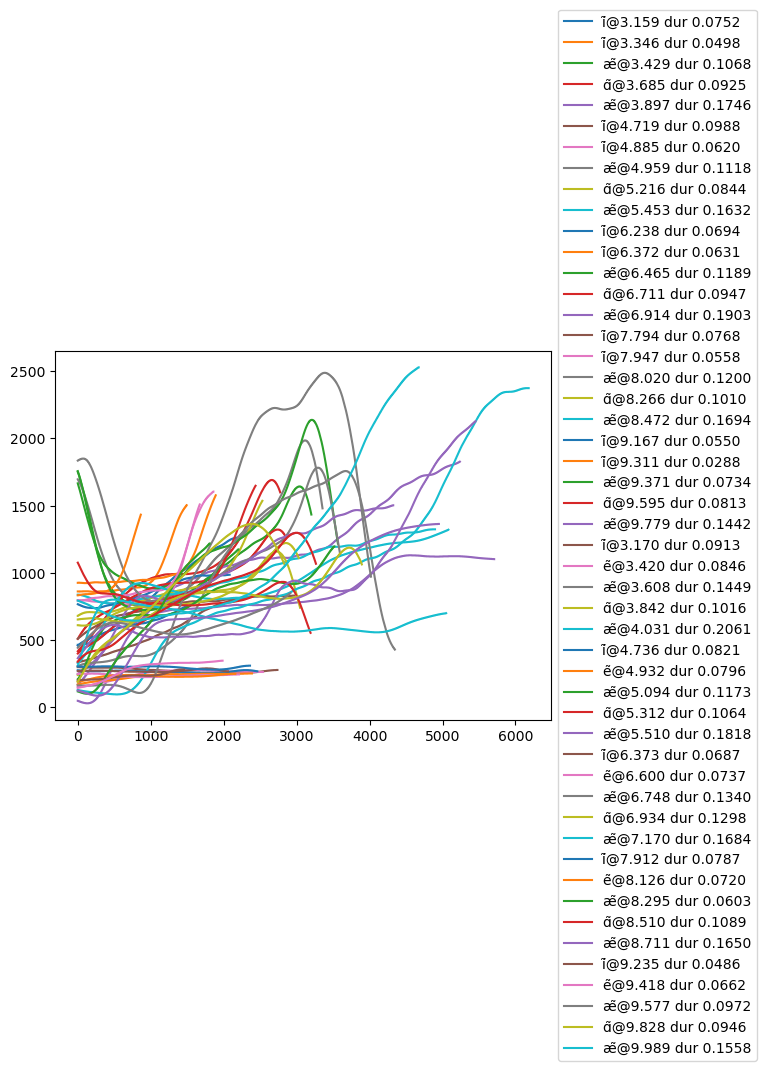

In [12]:
handles = []
ax = plt.subplot(111)
for idx in nsidx:
    handles.append(
        ax.plot(
            nsfl[idx],
            label=f"{vowdf.iloc[idx]['phone']}@{vowdf.iloc[idx]['t1_ph']:.3f} dur {vowdf.iloc[idx]['dur_ph']:.4f}"
        )[0]
    )
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5));

If you negate the selection criterion you get non-nasalized vowels instead.

In [13]:
oridx = (~vowdf['is_nasal']).to_numpy().nonzero()[0]
oridx

array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109])

By plotting these we can see that in general nasal flow is much lower for non-nasalized vowels, as expected.

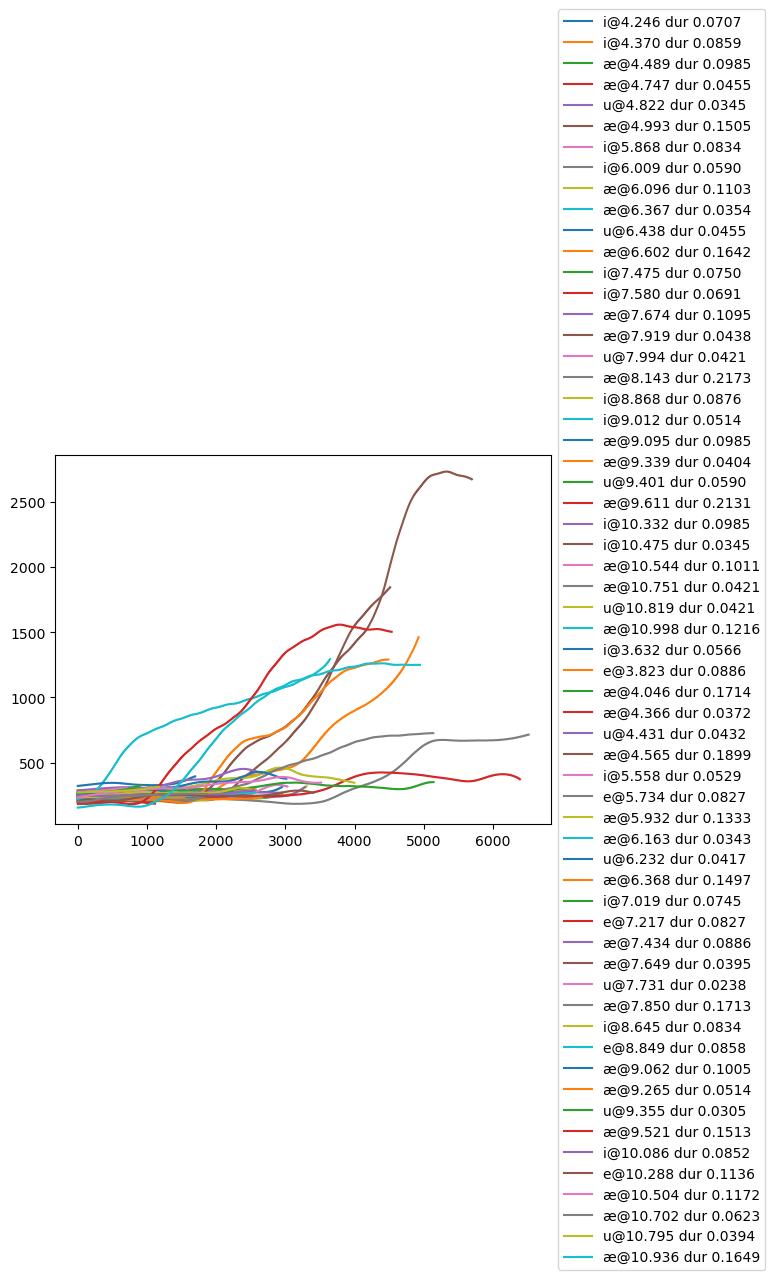

In [14]:
handles = []
ax = plt.subplot(111)
for idx in oridx:
    handles.append(
        ax.plot(
            nsfl[idx],
            label=f"{vowdf.iloc[idx]['phone']}@{vowdf.iloc[idx]['t1_ph']:.3f} dur {vowdf.iloc[idx]['dur_ph']:.4f}"
        )[0]
    )
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5));

### Data exploration

Perhaps you are now interested to look more closely at the tokens that show high nasal flow during a non-nasalized vowel. To take a look at these, we can find the signals corresponding to locations in `oridx` that have a maximum above a threshold. Note that we find a location index into another location index, `oridx`, and use that to construct `highflowidx`.

In [15]:
threshold = 500
oridx_selidx = np.nonzero(
    [np.max(nsfl[i]) >= threshold for i in oridx]
)[0]
highflowidx = oridx[oridx_selidx]
highflowidx

array([ 30,  36,  42,  54,  85,  91,  97, 103, 109])

Now use `highflowidx` to select signals and token rows. You can print out the name of the acquisition and timestamp of the phone so you can open the file in other software. (Maybe so you can correct a textgrid!)

In [16]:
for idx in highflowidx:
    print(vowdf.iloc[idx]['barename'], vowdf.iloc[idx]['t1_ph'])

pid_ros_jrl_20220512T110301__removeraguaF__0 4.993497204689641
pid_ros_jrl_20220512T110301__removeraguaF__0 6.601524226146806
pid_ros_jrl_20220512T110301__removeraguaF__0 8.143445760494192
pid_ros_jrl_20220512T110301__removeraguaF__0 10.998443249177384
pid_ros_jrl_20220512T110354__quebrarF__0 4.5647286201587445
pid_ros_jrl_20220512T110354__quebrarF__0 6.368197046874348
pid_ros_jrl_20220512T110354__quebrarF__0 7.849676945981097
pid_ros_jrl_20220512T110354__quebrarF__0 9.520737149457768
pid_ros_jrl_20220512T110354__quebrarF__0 10.935590862808592


Or you can choose an index from `highflowidx` and plot the nasal flow of the phone and play its audio right in this notebook.

Play æ


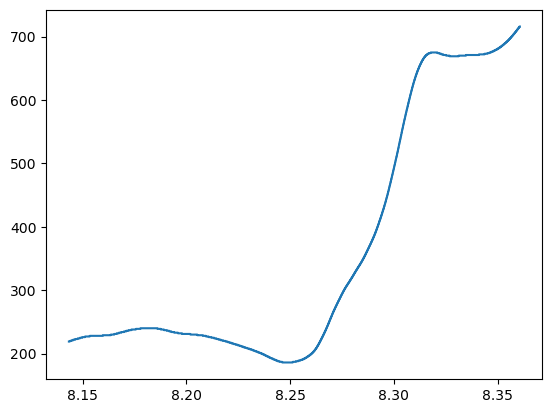

In [17]:
myidx = 42   # Choose a value from `highflowidx`
print(f"Play {vowdf['phone'].iloc[myidx]}")
plt.plot(times[myidx], nsfl[myidx])
ipd.Audio(aud[myidx], rate=rate)

Or load the audio for the entire word for playback.

In [18]:
wavpath = wavdir / vowdf['relpath'].iloc[myidx] / f"{vowdf['barename'].iloc[myidx]}.wav"
_rate, ts, audsig, orflsig, nsflsig = get_sigs(wavpath)
rng = np.arange(int(vowdf['t1_wd'].iloc[myidx] * rate), int(vowdf['t2_wd'].iloc[myidx] * rate))
print(f"Play {vowdf['word'].iloc[myidx]}")
ipd.Audio(audsig[rng], rate=rate)


Play t͡ʃiwiɾækʷæhusæ
